In [1]:
import torch
from torch import nn, optim
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

# For viewing grids purpose
import matplotlib.animation as animation
from IPython.display import HTML

In [15]:
# Configuration
batch_size = 64
image_size = 64
image_dim = 3
workers = 2
channels = 3
z_dim = 100
hidden_dim = 64
epochs = 20
beta1 = 0.5
ngpu = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
!unzip "/content/drive/MyDrive/Datasets/cats.zip" -d "data/cats"
!rm -R /content/data/.ipynb_checkpoints
!rm -R /content/data/cats/.ipynb_checkpoints
# !ls -a /content/data/cats

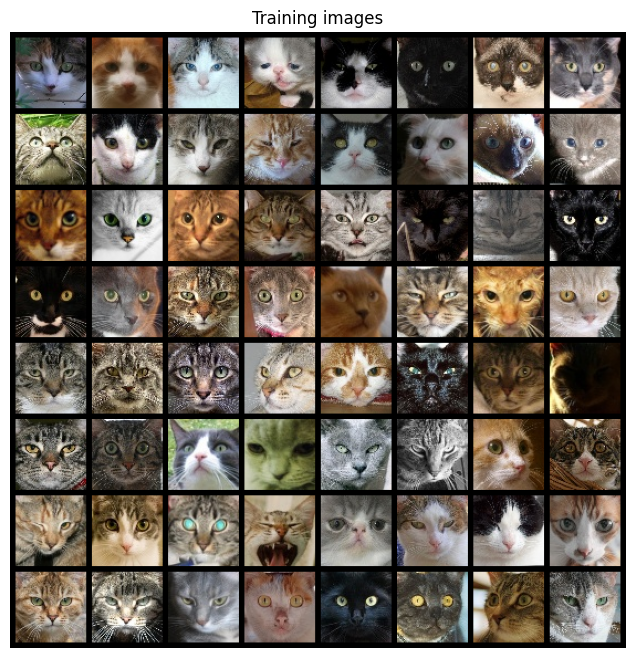

In [5]:
# Dataset
transform = transforms.Compose([
	transforms.Resize(image_size),
	transforms.CenterCrop(image_size),
	transforms.ToTensor(),
	transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

batch_size = 64
dset = ImageFolder(root="/content/data", transform=transform)
loader = DataLoader(dataset=dset, batch_size=batch_size, shuffle=True)

real_batch = next(iter(loader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [18]:
class Discriminator(nn.Module):
	def __init__(self, image_dim, hidden_dim):
		super().__init__()

		def block(in_features, out_features, kernel_size, stride, padding, first_layer=False, last_layer=False):
			layers = []
			layers.append(
				nn.Conv2d(
					in_channels=in_features,
					out_channels=out_features,
					kernel_size=kernel_size,
					stride=stride,
					padding=padding,
					bias=False)
			)
			if first_layer:
				layers.append(
					nn.LeakyReLU(negative_slope=0.2, inplace=True)
				)

			elif last_layer:
				layers.append(
					nn.LeakyReLU(negative_slope=0.2)
				)

			else:
				layers.extend([
					# nn.Dropout(p=0.8),
					nn.BatchNorm2d(num_features=out_features),
					nn.LeakyReLU(negative_slope=0.2, inplace=True)
				])

			return layers

		self.model = nn.Sequential(
      # (3, 64, 64)
			*block(image_dim, hidden_dim, 4, 2, 1, first_layer=True), # (64, 32, 32)
			*block(hidden_dim * 1, hidden_dim * 2, 4, 2, 1), # (128, 16, 16)
			*block(hidden_dim * 2, hidden_dim * 4, 4, 2, 1), # (256, 8, 8)
			*block(hidden_dim * 4, hidden_dim * 8, 4, 2, 1), # (512, 4, 4)
			*block(hidden_dim * 8, 1, 4, 1, 0, last_layer=True), # (1)
		)

	def forward(self, x):
		return self.model(x)

In [7]:
class Generator(nn.Module):
	def __init__(self, image_dim, z_dim, hidden_dim):
		super().__init__()
		def block(in_features, out_features, kernel_size, stride, padding, last_layer=False):
			layers = []
			layers.append(
				nn.ConvTranspose2d(
					in_channels=in_features,
					out_channels=out_features,
					kernel_size=kernel_size,
					stride=stride,
					padding=padding,
					bias=False
				)
			)
			if not last_layer:
				layers.extend([
					nn.BatchNorm2d(num_features=out_features),
					nn.ReLU(inplace=False)
				])
			else:
				layers.append(
					nn.Tanh()
				)
			return layers

		self.model = nn.Sequential(
			# (100, 1, 1)
			*block(z_dim, hidden_dim * 8, 4, 1, 0), # (512, 4, 4)
			*block(hidden_dim * 8, hidden_dim * 4, 4, 2, 1), # (256, 8, 8)
			*block(hidden_dim * 4, hidden_dim * 2, 4, 2, 1), # (128, 16, 16)
			*block(hidden_dim * 2, hidden_dim * 1, 4, 2, 1), # (64, 32, 32)
			*block(hidden_dim, image_dim, 4, 2, 1, last_layer=True) # (3, 64, 64)
		)

	def forward(self, x):
		return self.model(x)

In [8]:
def weight_init(m):
	classname = m.__class__.__name__
	if classname.find('Conv') != -1:
		nn.init.normal_(tensor=m.weight.data, mean=0., std=0.02)
	elif classname.find('BatchNorm') != -1:
		nn.init.normal_(tensor=m.weight.data, mean=1., std=0.02)
		nn.init.constant_(m.bias.data, 0)

In [16]:
def wasserstein_loss(y_real, y_fake):
    return -torch.mean(y_real) + torch.mean(y_fake)

In [ ]:
gen = Generator(image_dim=image_dim, z_dim=z_dim, hidden_dim=hidden_dim).to(device)
disc = Discriminator(image_dim=image_dim, hidden_dim=hidden_dim).to(device)

gen.apply(weight_init)
disc.apply(weight_init)

learning_rate=1e-4
opt_gen = optim.RMSprop(gen.parameters(), lr=learning_rate)
opt_disc = optim.Adam(disc.parameters(), lr=learning_rate)

# Training loop
img_list = []
D_loss = []
G_loss = []
print_loss_interval = 50
view_grid_interval = 50

fixed_noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

print("Starting training loop...")
for epoch in range(epochs):
  for batch_idx, (real_images, _) in enumerate(loader):
    ### Discriminator ###
    real = real_images.to(device)
    batch = real.shape[0]

    noise = torch.randn((batch, z_dim, 1, 1)).to(device)
    fake = gen(noise).to(device)

    real_pred = disc(real).reshape(-1)
    fake_pred = disc(fake.detach()).reshape(-1)

    d_loss = wasserstein_loss(real_pred, fake_pred)
    D_loss.append(d_loss.item())

    ### Update discriminator ###
    disc.zero_grad()
    d_loss.backward()
    opt_disc.step()

    # Weight clipping
    for param in disc.parameters():
        param.data.clamp_(-0.01, 0.01)


    if batch_idx % 5 == 0:
      ### Generator ###
      output = disc(fake).reshape(-1)
      g_loss = -torch.mean(output)
      G_loss.append(g_loss.item())

      ### Update Generator ###
      gen.zero_grad()
      g_loss.backward()
      opt_gen.step()

    # Print loss after `print_loss_interval` batches.
    if batch_idx % print_loss_interval == 0:
      print(f"[{epoch}/{epochs}][{batch_idx}/{len(loader)}]\tD_loss: {d_loss.item()}\tG_loss: {g_loss.item()}")

    # View grid images after `view_grid_interval` batches.
    if batch_idx % view_grid_interval == 0:
      with torch.no_grad():
        fake = gen(fixed_noise).detach().to(device)
      plt.figure(figsize=(8, 8))
      grid = make_grid(fake, padding=5, normalize=True).cpu()
      grid = np.transpose(grid, (1, 2, 0))
      img_list.append(grid)
      plt.axis("off")
      plt.imshow(grid)
      plt.show()


In [ ]:
with torch.no_grad():
  noise = torch.randn((64, 100, 1, 1)).to(device)
  fake = gen(noise).detach().to(device)

plt.figure(figsize=(8, 8))
grid = make_grid(fake, padding=5, normalize=True).cpu()
grid = np.transpose(grid, (1, 2, 0))
plt.axis("off")
plt.imshow(grid)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss,label="G")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())